In [1]:
# native
import os

# modules
from utils import *
from dataset import *
from vgg19min import *
from resnet50min import *
from score import *
from trainer import *
from logger import *

from PIL import Image, ImageFilter

# pytorch
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.utils import make_grid
import matplotlib.pyplot as plt


class dotdict(dict):
    """
    a dictionary that supports dot notation
    as well as dictionary access notation
    usage: d = dotdict() or d = dotdict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct):
        super().__init__()
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = dotdict(value)
            self[key] = value


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


In [3]:
requirements = {
    torch: '1'
}

check_requirements(requirements)

config = dotdict({
    'inputSize': 224,
    'batchSize': 32,
    'rootPath': './space',
    'numberOfWorkers': 8
})

In [4]:
IMAGE_SIZE = (config.inputSize, config.inputSize)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

def load_data(dataset_name, split):
    dataset_path = os.path.join(config.rootPath, 'datasets', dataset_name)

    istrain = split == 'train'
    transforms = train_transforms if istrain else test_transforms

    dataset = MiniImageNetDataset(dataset_path, split=split, transforms=transforms)#raw_transforms)
    loader = DataLoader(dataset, batch_size=config.batchSize, shuffle=istrain, num_workers=config.numberOfWorkers)

    print('{} dataset {} has {} datapoints in {} batches'.format(split, dataset_name, len(dataset), len(loader)))

    return dataset, loader

# original_train_dataset, original_train_loader = load_data('miniimagenet', 'train')
# original_val_dataset, original_val_loader = load_data('miniimagenet', 'val')

# stylized_train_dataset, stylized_train_loader = load_data('stylized-miniimagenet-1.0', 'train')
# stylized_val_dataset, stylized_val_loader = load_data('stylized-miniimagenet-1.0', 'val')

# for dataset, loader in [
#     (original_train_dataset, original_train_loader),
#     (original_val_dataset, original_val_loader),
#     (stylized_train_dataset, stylized_train_loader),
#     (stylized_val_dataset, stylized_val_loader)
# ]:
#     print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

dataset_names = [
    'stylized-miniimagenet-1.0', 'stylized-miniimagenet-0.9', 'stylized-miniimagenet-0.8',
    'stylized-miniimagenet-0.7', 'stylized-miniimagenet-0.6', 'stylized-miniimagenet-0.5',
    'stylized-miniimagenet-0.4', 'stylized-miniimagenet-0.3', 'stylized-miniimagenet-0.2',
    'stylized-miniimagenet-0.1', 'stylized-miniimagenet-0.0', 'miniimagenet'
]

dataset_names = [
    'stylized-miniimagenet-1.0',
    'stylized-miniimagenet-0.0'
]

val_dataset_store = {}

for dataset_name in dataset_names:
    val_dataset_store[dataset_name] = load_data(dataset_name, 'val')


 28%|██▊       | 2847/10000 [00:00<00:00, 28468.26it/s]

val dataset stylized-miniimagenet-1.0 has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 28239.53it/s]

val dataset stylized-miniimagenet-0.0 has 10000 datapoints in 313 batches


In [5]:
%matplotlib inline

# def show(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)))

def show_image(index):
    fig = plt.figure(figsize=(15, 15))
    imagelist = []
    i = 1
    for dataset_name, (dataset, loader) in val_dataset_store.items():
        plt.subplot(4, 4, i)
        image = toImage(dataset[index][dataset.INDEX_IMAGE])
        plt.imshow(image)
        plt.title(dataset_name)
        plt.axis('off')
        plt.subplot(4, 4, i+2)
        filtered = image.filter(ImageFilter.FIND_EDGES)
        plt.imshow(filtered)
        plt.title(dataset_name)
        plt.axis('off')
        i = i + 1
    print(dataset[index][dataset.INDEX_LABEL])
    plt.show()
#     show(make_grid(imagelist, nrow=4))


alp


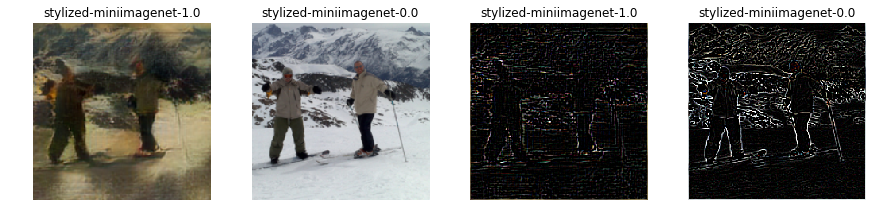

brain coral


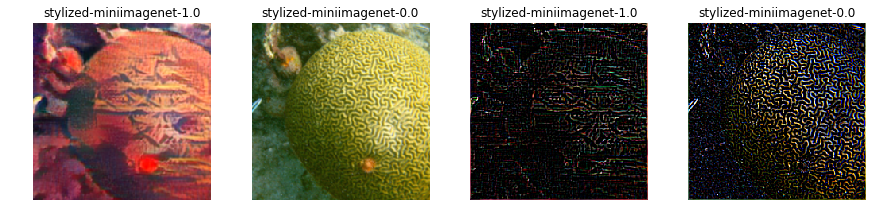

cougar


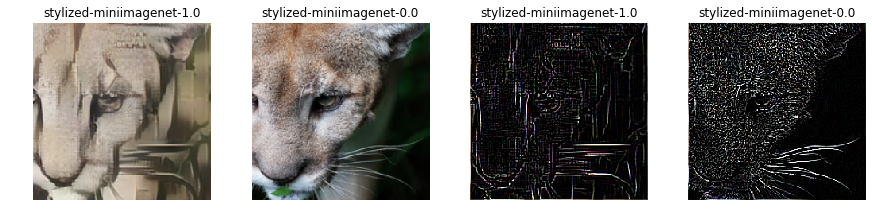

crane


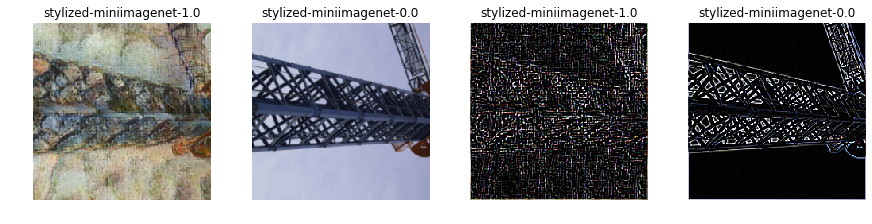

go-kart


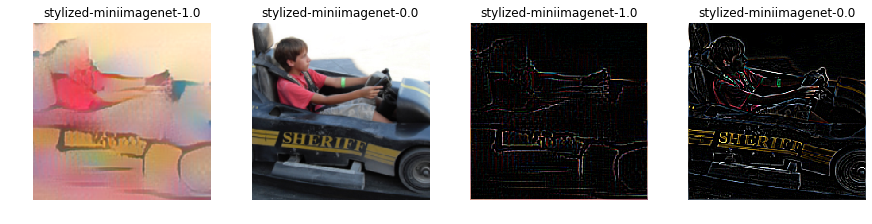

vestment


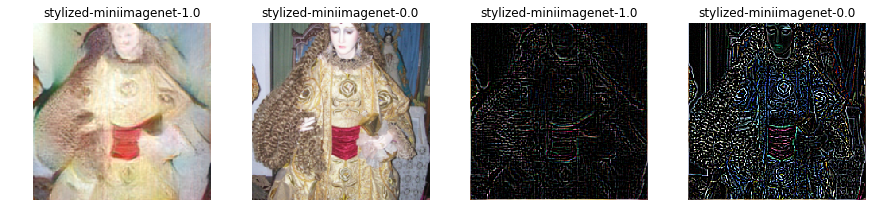

tailed frog


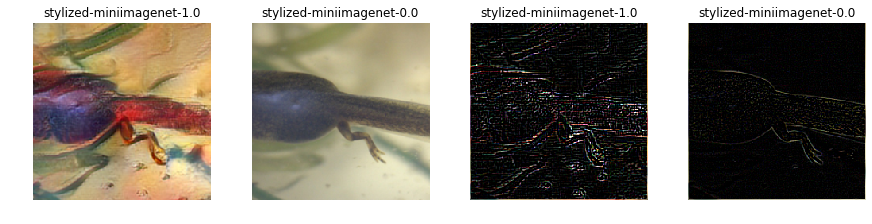

abacus


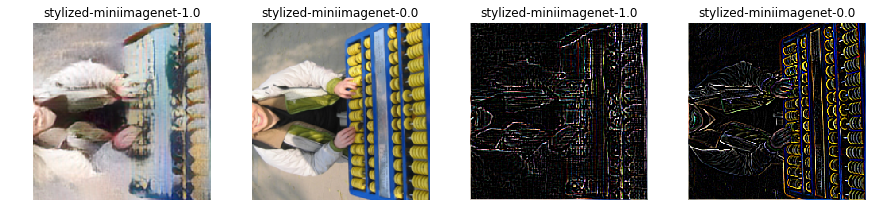

freight car


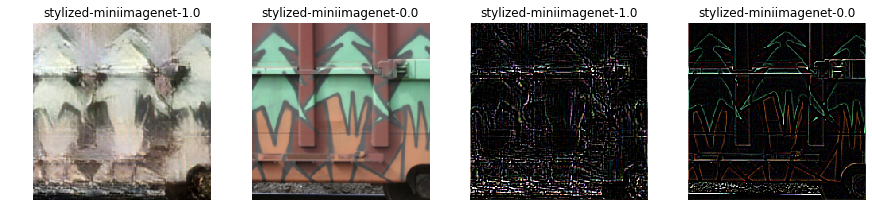

cardigan


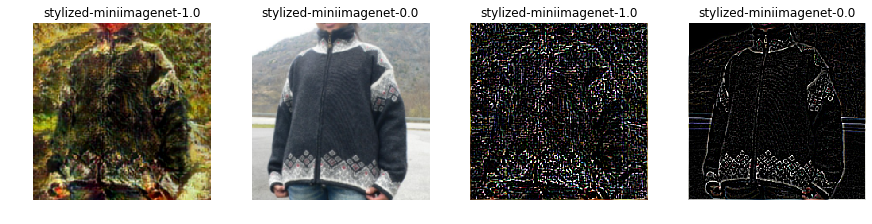

In [6]:
for i in range(0, 10):
    show_image(i)

In [7]:
def load_pair_data(dataset_names, split, target_type):
    input_dataset_path = os.path.join(config.rootPath, 'datasets', dataset_names[0])
    target_dataset_path = os.path.join(config.rootPath, 'datasets', dataset_names[1])

    istrain = split == 'train'
    transforms = train_transforms if istrain else test_transforms

    dataset = MiniImageNetPairDataset(input_dataset_path, target_dataset_path, split=split, transforms=transforms, target_type=target_type)
    loader = DataLoader(dataset, batch_size=config.batchSize, shuffle=istrain, num_workers=config.numberOfWorkers)

    print('{} dataset pair ({}, {}) has {} datapoints in {} batches'.format(split, dataset_names[0], dataset_names[1], len(dataset), len(loader)))

    return dataset, loader


100%|██████████| 10000/10000 [00:00<00:00, 14786.77it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 14925.81it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 14665.40it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 15002.39it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 12013.87it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


100%|██████████| 10000/10000 [00:00<00:00, 14978.97it/s]


val dataset pair (stylized-miniimagenet-0.0, stylized-miniimagenet-1.0) has 10000 datapoints in 313 batches


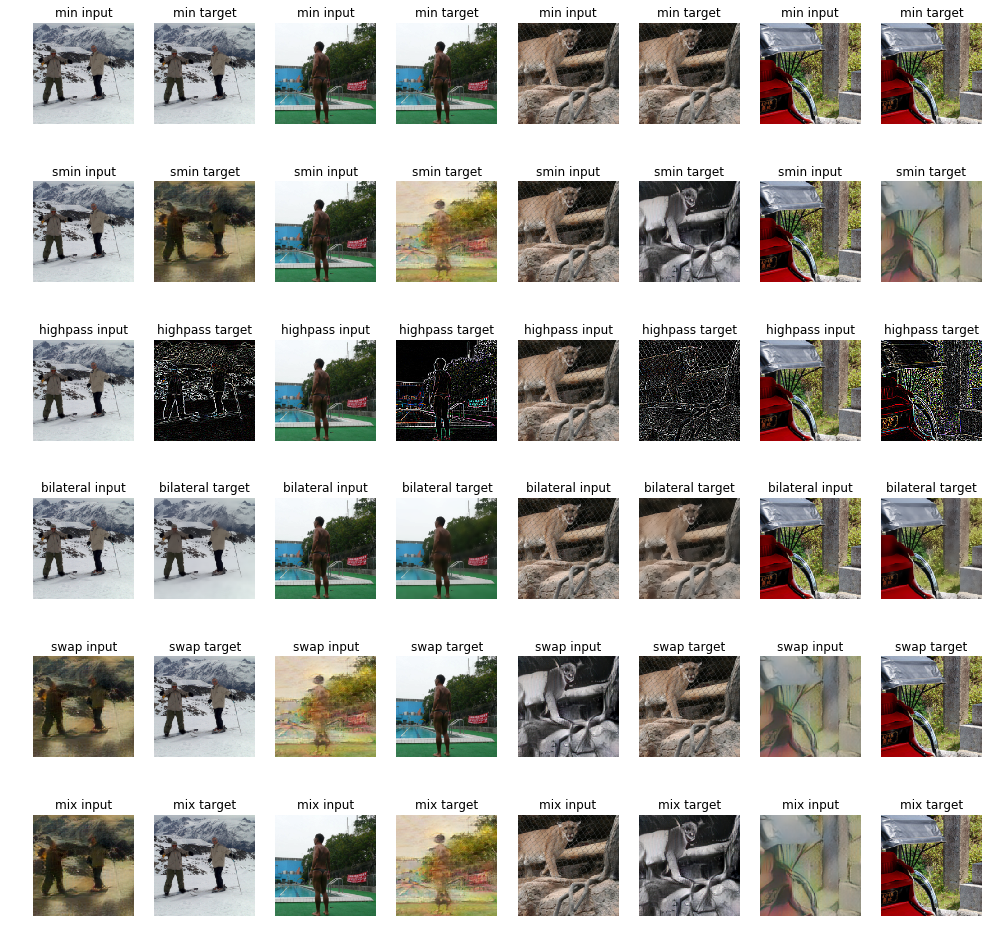

In [9]:
target_types = ['min', 'smin', 'highpass', 'bilateral', 'swap', 'mix']

plt.figure(figsize=(17, 17))
i = 1
for target_type in target_types:
    dataset, loader = load_pair_data(['stylized-miniimagenet-0.0', 'stylized-miniimagenet-1.0'], 'val', target_type)
    datapoint_indices = [0, 11, 100, 500]
    for datapoint_index in datapoint_indices:
        datapoint = dataset[datapoint_index]
        image1 = toImage(datapoint[dataset.INDEX_IMAGE])
        image2 = toImage(datapoint[dataset.INDEX_TARGET_IMAGE])
        plt.subplot(len(target_types), len(datapoint_indices) * 2, i)
        plt.imshow(image1)
        plt.title('{} input'.format(target_type))
        plt.axis('off')
        i = i + 1
        plt.subplot(len(target_types), len(datapoint_indices) * 2, i)
        plt.imshow(image2)
        plt.title('{} target'.format(target_type))
        plt.axis('off')
        i = i + 1
plt.show()
